# IMPORTING lIBRARIES

Importing basic library modules required for data manipulating operations and visualizations.

In [ ]:
%matplotlib inline
import re
import nltk
import spacy
import string
import pkg_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

Importing required objects from modules for Model Construction, Evaluation, Pre-Processing and Model Optimization.

NOTE: Used '!pip install' command for downloading external modules.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
!pip install textblob
from textblob import TextBlob
from sklearn.metrics import mean_squared_error 
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# IMPORTING DATA

In [ ]:
Train = pd.read_csv("/content/DataDashTrainingData - TwitterData.csv", encoding='utf8')
Test = pd.read_csv("/content/validation_wo_dpv.xlsx - Sheet1.csv", encoding='utf8')
print(Train.shape,Test.shape)

(1209, 14) (744, 10)


In [ ]:
Train.head(2)

,name,date,tweets,count_tweets,avg_tweet_likes,avg_tweet_retweets,chatter,followers,following,change,rank,rank on the following day (dpv1),rank 2 days later ( dpv2),rank 3 days later (dpv3)
0,company_46,10/23/2021,[{'text': '.@PM360online calls the work of our...,2.0,2.0,1.0,NaN,72753,496,0.000110,32.0,29.0,25.0,31.0
1,company_17,10/23/2021,[{'text': '@Amyrive21803741 Yikes! Sorry to he...,3.0,0.0,0.0,NaN,501445,65,-0.000088,91.0,81.0,83.0,84.0


DROPPING NAME AND DATE COLUMNS FROM TRAINING DATAFRAME AS THEY ARE NOT PRESENT IN THE TESTING DATASET AND ARE NOT REQUIRED FOR TRAINING.

In [ ]:
Train.drop(['name','date'], axis=1, inplace=True)
id=Test['ID']
Test.drop('ID', axis=1, inplace=True)
Test.head(2)

,tweets,count_tweets,avg_tweet_likes,avg_tweet_retweets,chatter,followers,following,change,rank
0,[{'text': 'JUST IN: Weâ€™re sharing #BloodCanc...,2.0,10.000000,0.5,[{'text': 'RT @SligoLGFA: Sligo LGFA countdown...,72930,496,0.000412,6.0
1,[{'text': '@Sadu_SBS DM us your order # &amp; ...,3.0,0.333333,0.0,[{'text': '@Abercrombie I bought a fewT-shirtâ...,501153,65,-0.000060,88.0


CHECKING FOR PRESENCE OF 'NaN' VALUES IN TRAINING DATA

In [ ]:
Train.isna().sum()

tweets                                    0
count_tweets                            202
avg_tweet_likes                           0
avg_tweet_retweets                        0
chatter                                 558
followers                                 0
following                                 0
change                                    0
rank                                      0
rank on the following day (dpv1)          0
rank 2 days later            ( dpv2)      0
rank 3 days later          (dpv3)         0
dtype: int64

CHECKING FOR PRESENCE OF 'NaN' VALUES IN TESTING DATA

In [ ]:
Test.isna().sum()

tweets                 0
count_tweets          90
avg_tweet_likes        0
avg_tweet_retweets     0
chatter                0
followers              0
following              0
change                 0
rank                   0
dtype: int64

1. RENAMING RANKS COLUMNS FOR CONVENIENCE IN TRAINING DATA
2. REPLACING 'NaN' VALUES IN TRAINING AND TESTING DATA WITH:

    A. 'MEAN' IN CASE OF COUNT_TWEETS COLUMN
    
    B. 'NULL STRING' IN CASE OF CHATTER COLUMN 


In [ ]:
Train.rename(columns = {'rank on the following day (dpv1)': 'rank1', 'rank 2 days later            ( dpv2)': 'rank2', "rank 3 days later          (dpv3)" : 'rank3'}, inplace = True)

imputer = SimpleImputer()
imputer.fit(Train["count_tweets"].values.reshape(-1, 1))
Train["count_tweets"] = imputer.transform(Train["count_tweets"].values.reshape(-1, 1))
imputer.fit(Test["count_tweets"].values.reshape(-1, 1))
Test["count_tweets"] = imputer.transform(Test["count_tweets"].values.reshape(-1, 1))

Train["chatter"].fillna("", inplace=True)

#PRE-PROCESSING DATA
THE DATA IN TWEETS AND CHATTER COLUMN CONTAINS DATA ABOUT TWEETS TWEETED BY COMPANIES AND PEOPLE. EACH ENTRY CONTAINS ALL THE TWEETS PRESENT IN THAT PARTICULAR THREAD.

CLEANING COLUMNS BY REMOVING PUNCTUATIONS, HASHTAGS, URLS, STOPWORDS AND SPECIAL CHARACTERS (EX: EMOJIS, CURRENCIES ETC..,), SO THAT ONLY THE TEXT WHICH IS TWEETED REMAINS.


In [ ]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_stopwords(text):
  text = text.split()
  text = [word for word in text
				if word not in set(stopwords.words('english'))]		
  text = ' '.join(text)
  return text

def special_characters(text):
  text=re.sub('[^A-Za-z]+', ' ', text)
  return text


Train["tweets"] = Train["tweets"].str.lower()
Train["tweets"] = Train["tweets"].apply(lambda text: remove_urls(text))
Train["tweets"] = Train["tweets"].apply(lambda text: remove_stopwords(text))
Train["tweets"] = Train["tweets"].apply(lambda text: remove_punctuation(text))
Train["tweets"] = Train["tweets"].str.replace('text','')
Train["tweets"] = Train["tweets"].str.replace('createdat','')
Train["tweets"] = Train["tweets"].str.replace('retweetcount','')
Train["tweets"] = Train["tweets"].str.replace('likes','')
Train["tweets"] = Train["tweets"].str.replace('datetimedatetime','')
Train["tweets"] = Train["tweets"].str.replace('tzinfodatetimetimezoneutc','')
Train["tweets"] = Train["tweets"].apply(lambda text: special_characters(text))

Train["chatter"] = Train["chatter"].str.lower()
Train["chatter"] = Train["chatter"].apply(lambda text: remove_urls(text))
Train["chatter"] = Train["chatter"].apply(lambda text: remove_punctuation(text))
Train["chatter"] = Train["chatter"].apply(lambda text: remove_stopwords(text))
Train["chatter"] = Train["chatter"].str.replace('text','')
Train["chatter"] = Train["chatter"].str.replace('createdat','')
Train["chatter"] = Train["chatter"].str.replace('retweetcount','')
Train["chatter"] = Train["chatter"].str.replace('likes','')
Train["chatter"] = Train["chatter"].str.replace('datetimedatetime','')
Train["chatter"] = Train["chatter"].str.replace('tzinfodatetimetimezoneutc','')
Train["chatter"] = Train["chatter"].apply(lambda text: special_characters(text))

Test["tweets"] = Test["tweets"].str.lower()
Test["tweets"] = Test["tweets"].apply(lambda text: remove_urls(text))
Test["tweets"] = Test["tweets"].apply(lambda text: remove_stopwords(text))
Test["tweets"] = Test["tweets"].apply(lambda text: remove_punctuation(text))
Test["tweets"] = Test["tweets"].str.replace('text','')
Test["tweets"] = Test["tweets"].str.replace('createdat','')
Test["tweets"] = Test["tweets"].str.replace('retweetcount','')
Test["tweets"] = Test["tweets"].str.replace('likes','')
Test["tweets"] = Test["tweets"].str.replace('datetimedatetime','')
Test["tweets"] = Test["tweets"].str.replace('tzinfodatetimetimezoneutc','')
Test["tweets"] = Test["tweets"].apply(lambda text: special_characters(text))

Test["chatter"] = Test["chatter"].str.lower()
Test["chatter"] = Test["chatter"].apply(lambda text: remove_urls(text))
Test["chatter"] = Test["chatter"].apply(lambda text: remove_punctuation(text))
Test["chatter"] = Test["chatter"].apply(lambda text: remove_stopwords(text))
Test["chatter"] = Test["chatter"].str.replace('text','')
Test["chatter"] = Test["chatter"].str.replace('createdat','')
Test["chatter"] = Test["chatter"].str.replace('retweetcount','')
Test["chatter"] = Test["chatter"].str.replace('likes','')
Test["chatter"] = Test["chatter"].str.replace('datetimedatetime','')
Test["chatter"] = Test["chatter"].str.replace('tzinfodatetimetimezoneutc','')
Test["chatter"] = Test["chatter"].apply(lambda text: special_characters(text))

CREATING A COPY OF TRAINING AND TESTING DATA FOR CONVENIENCE 

In [ ]:
train=Train.copy(deep=False)
test=Test.copy(deep=False)

SENTIMENT EXTRACTION:

EACH TWEET HAS A SUBJECTIVITY INDEX INDICATING WHETHER THE TWEETS IS A FACT OR AN OPINION/BELIEF AND A POLARITY INDEX INDICATING WHETHER THE TWEETS IS A POSITIVE OR A NEGATIVE TWEET.



USING 'TEXTBLOB' FOR EXTRACTING SUBJECTIVITY AND POLARITY OF THE TWEETS AND STORING THEM AS COLUMNS FOR ANALYSIS IN TRAINING DATA.

In [ ]:
tweets_subjectivity=[]
tweets_polarity=[]

for i in range(1209):
  testimonial_1 = TextBlob(train["tweets"][i])
  tweets_subjectivity.append(testimonial_1.sentiment.subjectivity)
  tweets_polarity.append(testimonial_1.sentiment.polarity)

chatter_subjectivity=[]
chatter_polarity=[]

for i in range(1209):
  testimonial_2 = TextBlob(train["chatter"][i])
  chatter_subjectivity.append(testimonial_2.sentiment.subjectivity)
  chatter_polarity.append(testimonial_2.sentiment.polarity)

train.insert(1,'tweets_subjectivity',tweets_subjectivity)
train.insert(2,'tweets_polarity',tweets_polarity)
train.insert(7,'chatter_subjectivity',chatter_subjectivity)
train.insert(8,'chatter_polarity',chatter_polarity)
train.drop(['tweets','chatter'], axis=1, inplace=True)


USING 'TEXTBLOB' FOR EXTRACTING SUBJECTIVITY AND POLARITY OF THE TWEETS AND STORING THEM AS COLUMNS FOR ANALYSIS IN TESTING DATA.

In [ ]:
tweets_subjectivity=[]
tweets_polarity=[]

for i in range(744):
  testimonial_1 = TextBlob(test["tweets"][i])
  tweets_subjectivity.append(testimonial_1.sentiment.subjectivity)
  tweets_polarity.append(testimonial_1.sentiment.polarity)

chatter_subjectivity=[]
chatter_polarity=[]

for i in range(744):
  testimonial_2 = TextBlob(test["chatter"][i])
  chatter_subjectivity.append(testimonial_2.sentiment.subjectivity)
  chatter_polarity.append(testimonial_2.sentiment.polarity)

test.insert(1,'tweets_subjectivity',tweets_subjectivity)
test.insert(2,'tweets_polarity',tweets_polarity)
test.insert(7,'chatter_subjectivity',chatter_subjectivity)
test.insert(8,'chatter_polarity',chatter_polarity)

test.drop(['tweets','chatter'], axis=1, inplace=True)

DROPPED THE TWEETS AND CHATTER COLUMNS IN BOTH TRAINING AND TESTING DATA TO AVOID CORRELATION BETWEEN NEWLY FORMED AND OLD COLUMNS.

In [ ]:
train.describe()

,tweets_subjectivity,tweets_polarity,count_tweets,avg_tweet_likes,avg_tweet_retweets,chatter_subjectivity,chatter_polarity,followers,following,change,rank,rank1,rank2,rank3
count,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1.209000e+03,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,0.420217,0.141168,13.527309,39.418935,8.591025,0.222437,0.071736,1.122702e+06,8081.205128,0.000115,47.000000,47.000000,47.000000,47.000000
std,0.297173,0.236513,33.938991,387.018589,82.324540,0.252060,0.114790,2.984283e+06,17708.493189,0.000305,26.855589,26.855828,26.855836,26.855836
min,0.000000,-0.600000,1.000000,0.000000,0.000000,0.000000,-0.340909,5.110700e+04,4.000000,-0.000357,1.000000,1.000000,1.000000,1.000000
25%,0.066667,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.094500e+05,337.000000,0.000000,24.000000,24.000000,24.000000,24.000000
50%,0.489773,0.102899,7.000000,1.000000,0.166667,0.000000,0.000000,3.250900e+05,1397.000000,0.000064,47.000000,47.000000,47.000000,47.000000
75%,0.638636,0.275253,13.527309,8.000000,2.000000,0.478680,0.145191,7.733170e+05,5489.000000,0.000157,70.500000,70.000000,70.000000,70.000000
max,1.000000,1.000000,520.000000,11462.375000,2166.375000,0.815385,0.769231,2.389704e+07,105215.000000,0.007013,93.000000,93.000000,93.000000,93.000000


REMOVING OUTLIERS PRESENT IN BOTH TRAINING AND TESTING DATA TO REDUCE INACCURACY

In [ ]:
def remove_outliers(x):
  Column_Names=x.columns
  for j in Column_Names:
      try:
          xy=x[j]    
          mydata=pd.DataFrame()
          updated=[]
          Q1,Q3=np.percentile(xy,[25,75])
          IQR=Q3-Q1
          minimum=Q1-1.5*IQR
          maximum=Q3+1.5*IQR
          for i in xy:
              if(i>maximum):
                  i=maximum
                  updated.append(i)
              elif(i<minimum):
                  i=minimum
                  updated.append(i)
              else:
                  updated.append(i)
          x[j]=updated
      except:
          continue
  return x

train = remove_outliers(train)
test = remove_outliers(test)

In [ ]:
train.describe()

,tweets_subjectivity,tweets_polarity,count_tweets,avg_tweet_likes,avg_tweet_retweets,chatter_subjectivity,chatter_polarity,followers,following,change,rank,rank1,rank2,rank3
count,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1.209000e+03,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000,1209.000000
mean,0.420217,0.139451,9.606341,5.101267,1.263847,0.222437,0.070042,5.432510e+05,3872.142266,0.000093,47.000000,47.000000,47.000000,47.000000
std,0.297173,0.222421,8.256832,7.074368,1.790641,0.252060,0.108166,5.484897e+05,4860.345788,0.000128,26.855589,26.855828,26.855836,26.855836
min,0.000000,-0.412879,1.000000,0.000000,0.000000,0.000000,-0.217786,5.110700e+04,4.000000,-0.000236,1.000000,1.000000,1.000000,1.000000
25%,0.066667,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.094500e+05,337.000000,0.000000,24.000000,24.000000,24.000000,24.000000
50%,0.489773,0.102899,7.000000,1.000000,0.166667,0.000000,0.000000,3.250900e+05,1397.000000,0.000064,47.000000,47.000000,47.000000,47.000000
75%,0.638636,0.275253,13.527309,8.000000,2.000000,0.478680,0.145191,7.733170e+05,5489.000000,0.000157,70.500000,70.000000,70.000000,70.000000
max,1.000000,0.688131,30.818272,20.000000,5.000000,0.815385,0.362977,1.769118e+06,13217.000000,0.000393,93.000000,93.000000,93.000000,93.000000


#Training Model


BEFORE TRAINING DATA, CHECKING FOR CORRELATION BETWEEN ALL THE COLUMNS IN THE TRAINING DATASET, FOR DETERMINING BEHAVIOUR OF EACH COLUMN WITH RESPECT TO OTHER COLUMNS.

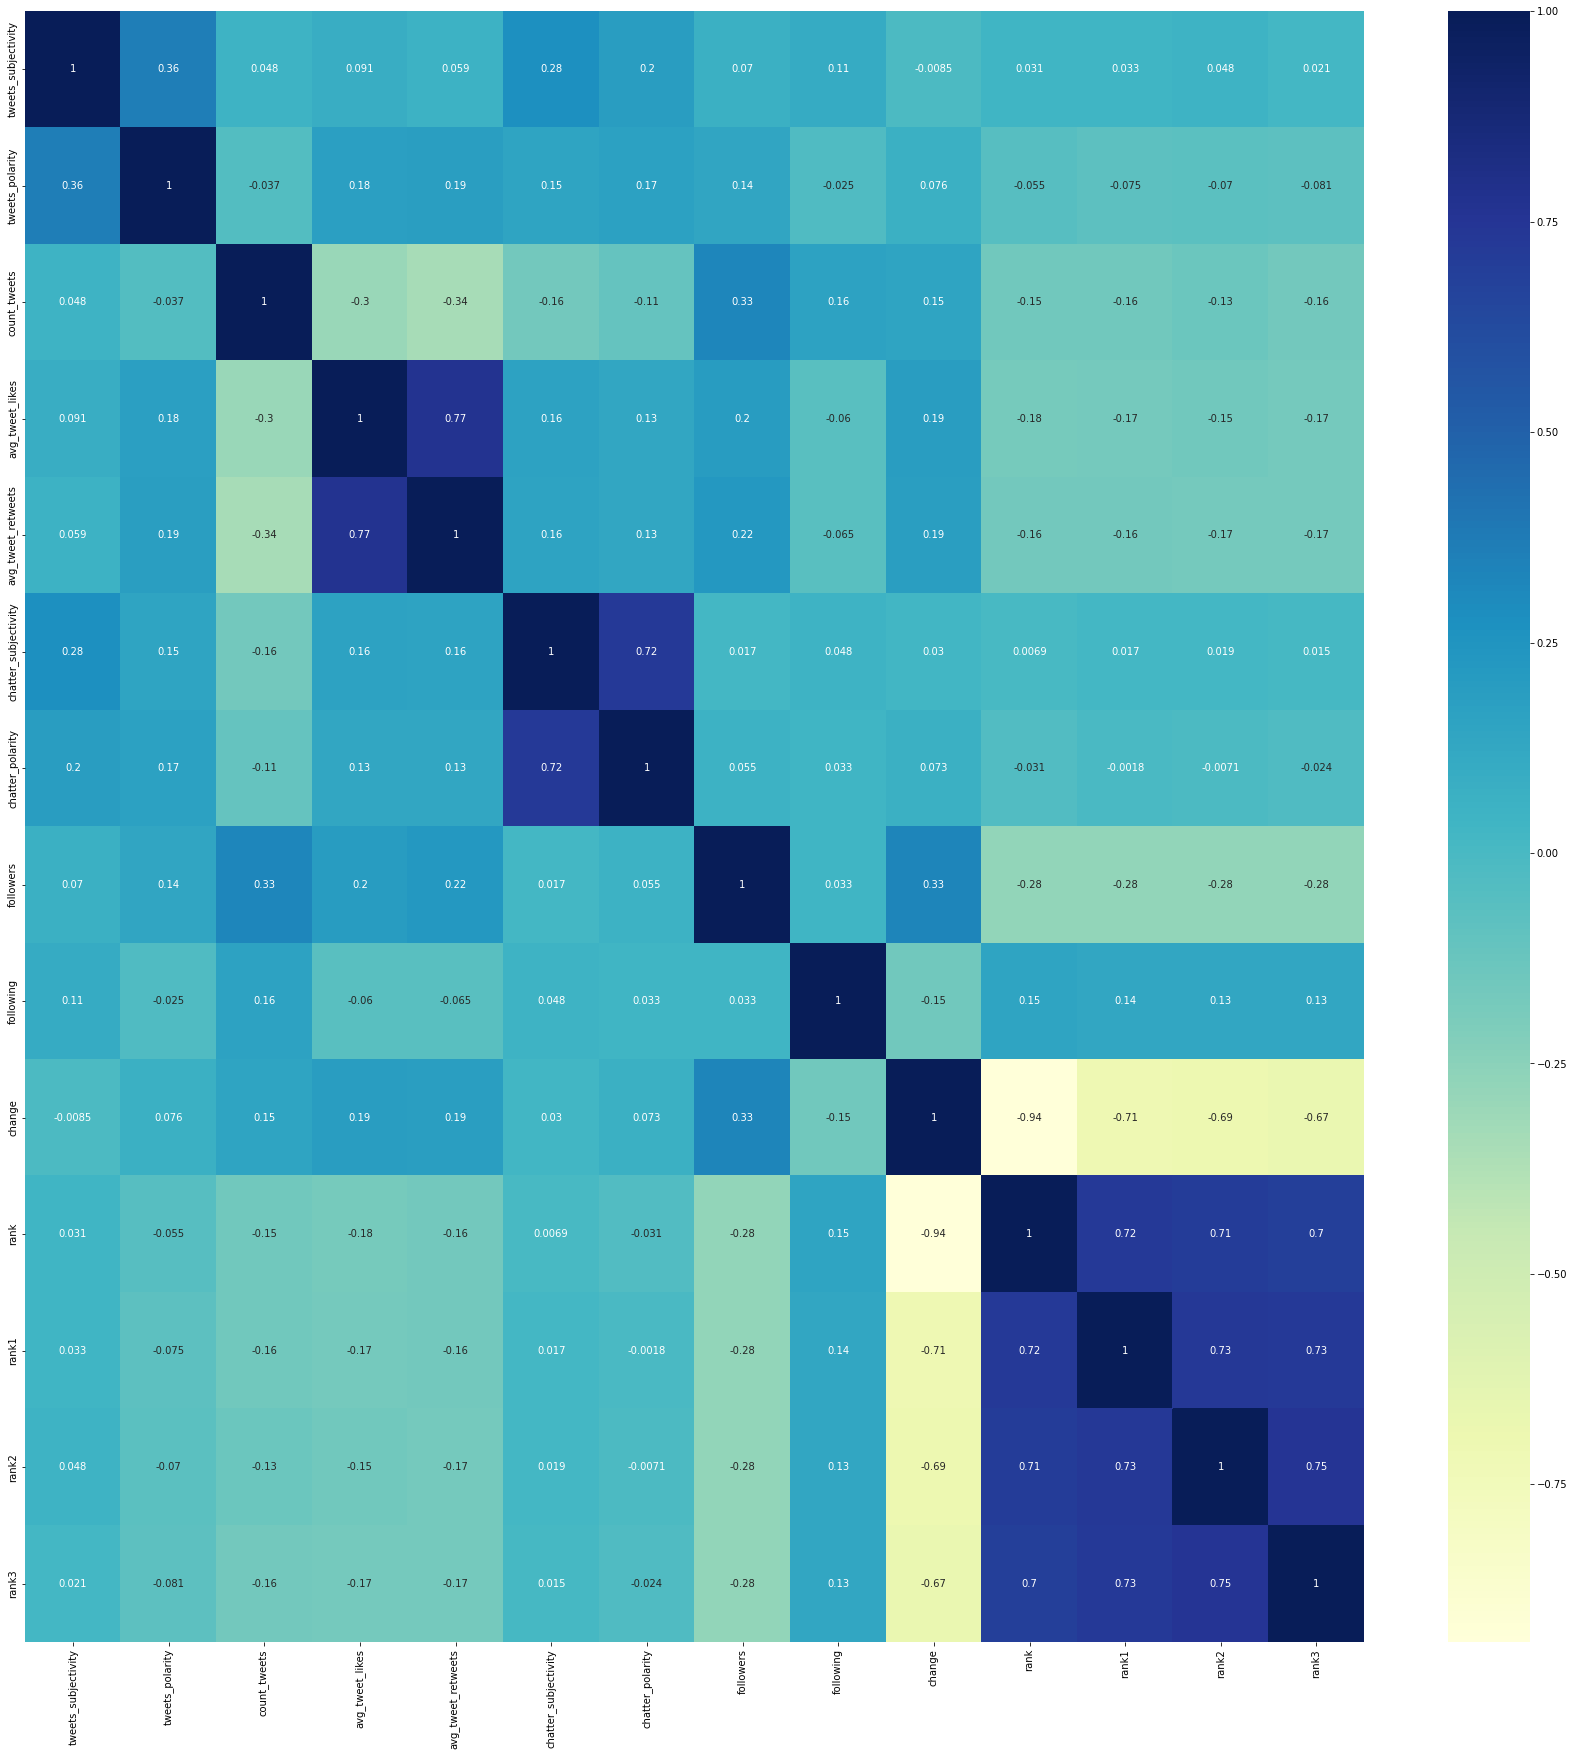

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(train.corr(),annot=True,cmap="YlGnBu");

In [ ]:
test.columns

Index(['tweets_subjectivity', 'tweets_polarity', 'count_tweets',
       'avg_tweet_likes', 'avg_tweet_retweets', 'chatter_subjectivity',
       'chatter_polarity', 'followers', 'following', 'change', 'rank'],
      dtype='object')

PREPARING DATASETS AND COLUMNS IN THEM FOR TRAINING, VALIDATING AND PEDICTING.

In [ ]:
#REMOVING COUNT_TWEETS BASED ON CORRELATION COEFFECIENTS 
x_1_test=test[['tweets_subjectivity','tweets_polarity','avg_tweet_likes','chatter_subjectivity','chatter_polarity','followers', 'following', 'rank']]
x_2_test=test[['tweets_subjectivity','tweets_polarity', 'count_tweets','avg_tweet_likes','chatter_subjectivity','chatter_polarity', 'followers', 'following', 'rank']]
x_3_test=test[['tweets_subjectivity','tweets_polarity', 'count_tweets','avg_tweet_likes','chatter_subjectivity','chatter_polarity','followers', 'following', 'rank']]

y_3=train['rank3']
y_2=train['rank2']
y_1=train['rank1']

x_1=train[['tweets_subjectivity','tweets_polarity','avg_tweet_likes','chatter_subjectivity','chatter_polarity',  'followers', 'following', 'rank']]
x_2=train[['tweets_subjectivity','tweets_polarity', 'count_tweets','avg_tweet_likes','chatter_subjectivity','chatter_polarity', 'followers', 'following', 'rank', 'rank1']]
x_3=train[['tweets_subjectivity','tweets_polarity', 'count_tweets','avg_tweet_likes','chatter_subjectivity','chatter_polarity', 'followers', 'following', 'rank', 'rank1','rank2']]

#COMBINING RANK COLUMNS TO REDUCE INACCURACY DUE TO CORRELATION EFFECT
x_3['rank']=x_3['rank']+x_3['rank1']+x_3['rank2']
x_3.drop(['rank1','rank2'],axis=1,inplace=True)

def product(x,y):
  z=[]
  for i in range(len(x)):
    z.append(x[i]*y[i])
  return z
def transform(x):
  y = product(x['tweets_subjectivity'],x['tweets_polarity'])
  z = product(x['chatter_subjectivity'],x['chatter_polarity'])
  x.insert(0,column='tweets_Sentiment',value=y)
  x.insert(1,column='chatter_Sentiment',value=z)
  x.drop(['tweets_subjectivity', 'tweets_polarity','chatter_subjectivity','chatter_polarity'], axis=1, inplace=True)
  return x

x_1 = transform(x_1)
x_2 = transform(x_2)
x_3 = transform(x_3)
x_1_test = transform(x_1_test)
x_2_test = transform(x_2_test)
x_3_test = transform(x_3_test)

# x_1_train,x_1_val,y_1_train,y_1_val=train_test_split(x_1,y_1,test_size=0.2,random_state=42)
# x_2_train,x_2_val,y_2_train,y_2_val=train_test_split(x_2,y_2,test_size=0.2,random_state=42)
# x_3_train,x_3_val,y_3_train,y_3_val=train_test_split(x_3,y_3,test_size=0.2,random_state=42)


#HYPERPARAMETER TUNING

FINDING OUT BEST PARAMETERS FOR 'KNeighborsRegressor()' USING GRIDSEARCHCV WITH NUMBER OF FOLDS AS 10

In [ ]:
leaf_size = list(range(1,40))
n_neighbors = list(range(1,30))

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors)
rgr = GridSearchCV(KNeighborsRegressor(), hyperparameters, cv=10)

def tuner(x,y):
  best_model = rgr.fit(x,y)
  print('leaf_size =', best_model.best_estimator_.get_params()['leaf_size'])
  print('n_neighbors =', best_model.best_estimator_.get_params()['n_neighbors'])

tuner(x_1,y_1)
tuner(x_2,y_2)
tuner(x_3,y_3)

leaf_size = 1
n_neighbors = 10
leaf_size = 1
n_neighbors = 9
leaf_size = 1
n_neighbors = 9


TRAINING AND PREDICTING USING KneighborsRegressor() WITH BEST PARAMETERS OBTAINED FROM GRIDSEARCHCV

In [ ]:
output = pd.DataFrame()
output["ID"] = id

np.random.seed(42)
model1 = KNeighborsRegressor(n_neighbors=8, leaf_size=1, p=1)
model1.fit(x_1,y_1)
y_1_pred = (model1.predict(x_1_test)).astype(int)
# y_1_val_pred = model1.predict(x_1_val)
# print(mean_squared_error(y_1_val_pred,y_1_val)**0.5)

output['rank1']=y_1_pred.astype(int)
x_2_test['rank1']=y_1_pred
x_3_test['rank1']=y_1_pred

np.random.seed(42)
model2 = KNeighborsRegressor(n_neighbors=8, leaf_size=1, p=1)
model2.fit(x_2,y_2)
y_2_pred = (model2.predict(x_2_test)).astype(int)
# y_2_val_pred = model2.predict(x_2_val)
# print(mean_squared_error(y_2_val_pred,y_2_val)**0.5)

output['rank2']=y_2_pred
x_3_test['rank2']=y_2_pred

x_3_test['rank']=x_3_test['rank']+x_3_test['rank1']+x_3_test['rank2']
x_3_test.drop(['rank1','rank2'],axis=1,inplace=True)

np.random.seed(42)
model3 = KNeighborsRegressor(n_neighbors=8, leaf_size=1, p=1)
model3.fit(x_3,y_3)
y_3_pred = (model3.predict(x_3_test)).astype(int)
# y_3_val_pred = model3.predict(x_3_val)
# print(mean_squared_error(y_3_val_pred,y_3_val)**0.5)

output['rank3'] = y_3_pred
output.head()

,ID,rank1,rank2,rank3
0,1,29,21,19
1,2,84,83,83
2,3,72,73,74
3,4,63,70,71
4,5,48,48,48


EXPORTING PREDICTIONS FOR SUBMISSION

In [ ]:
output.to_csv("./submission_file_.csv",index=False)

## EXPERIMENTAL NOTES


STAGE 3

n_neighbors=10, leaf_size=1, p=1 16.178774292365468

n_neighbors=9, leaf_size=1, p=1 17.174097057304078

n_neighbors=8, leaf_size=1, p=1 14.664890501798917

STAGE 2

15.785865630968999
17.41806319944427
14.988604486836323 = added ranks in x_3

15.785865630968999
17.59152688602721
14.988604486836323 = added ranks in x_2 and x_3


STAGE 1

k neighbors
15.808764176664427
17.421289341321717
15.001477888627347

k neighbors without avg_tweet_retweets
15.808487102275473
17.41806319944427
14.998739616469267

k neighbors without avg tweet retweets & count tweets 15.785865630968999
17.50415771152907
15.043291522625982

k neighbors without avg tweet retweets & count tweets (in x_1)
15.785865630968999 17.41806319944427 14.998739616469267


k neighbors without avg tweet retweets & count tweets (in x_1, x_2)
15.785865630968999
17.50415771152907
14.998739616469267